In [17]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from skimage import io, color, exposure

import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_dir = "../input/flowers-recognition/flowers"

In [18]:
def adaptive_histogram(I):
    I_lab = color.rgb2lab(I)
    I_lab[:,:,0] = I_lab[:,:,0]/100

    I_recon_l = exposure.equalize_adapthist(I_lab[:,:,0],
                                            kernel_size = (120,120),
                                            clip_limit = 0.01)
    I_recon_l = I_recon_l * 100
    I_lab[:,:,0] = I_recon_l
    I_recon_color = color.lab2rgb(I_lab)

    return I_recon_color

In [ ]:
I0 = io.imread("../input/flowers-recognition/flowers/daisy/10140303196_b88d3d6cec.jpg")
I1 = io.imread("../input/flowers-recognition/flowers/dandelion/10777398353_5a20bb218c.jpg")
I2 = io.imread("../input/flowers-recognition/flowers/rose/10503217854_e66a804309.jpg")
I3 = io.imread("../input/flowers-recognition/flowers/sunflower/12282924083_fb80aa17d4_n.jpg")
I4 = io.imread("../input/flowers-recognition/flowers/tulip/10163955604_ae0b830975_n.jpg")

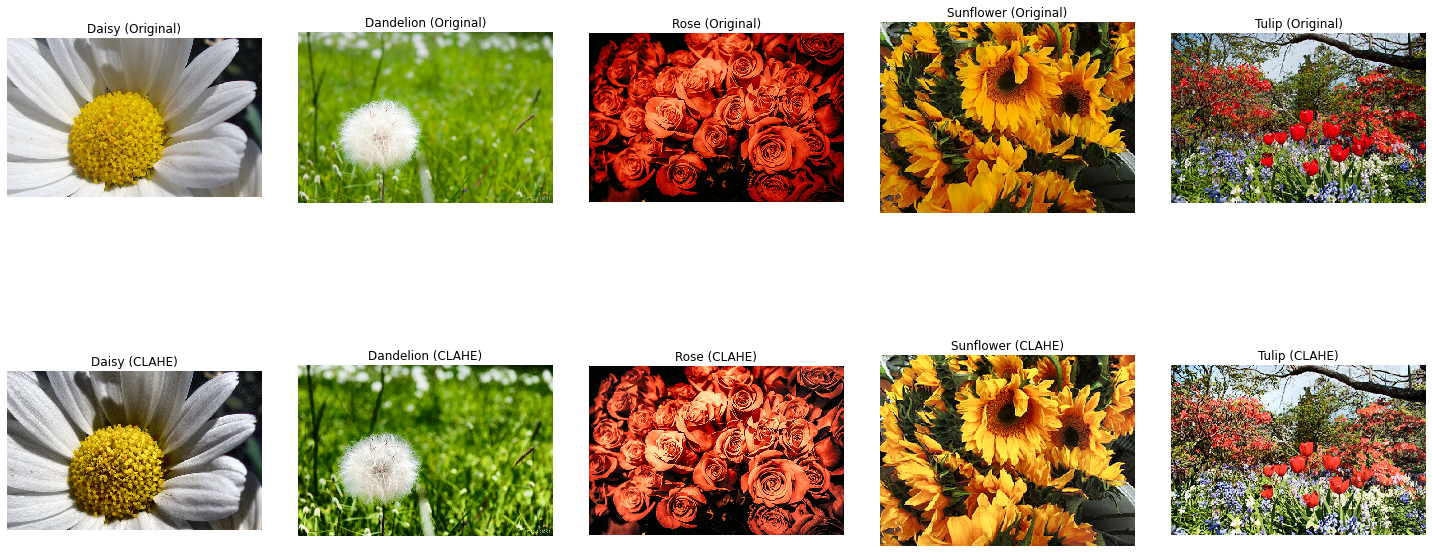

In [65]:
plt.rcParams['figure.figsize'] = (20,15)

plt.subplot(3, 5, 1)
io.imshow(I0)
plt.axis("off")
plt.title("Daisy (Original)")

plt.subplot(3, 5, 2)
io.imshow(I1)
plt.axis("off")
plt.title("Dandelion (Original)")

plt.subplot(3, 5, 3)
io.imshow(I2)
plt.axis("off")
plt.title("Rose (Original)")

plt.subplot(3, 5, 4)
io.imshow(I3)
plt.axis("off")
plt.title("Sunflower (Original)")

plt.subplot(3, 5, 5)
io.imshow(I4)
plt.axis("off")
plt.title("Tulip (Original)")


plt.subplot(3, 5, 6)
io.imshow(adaptive_histogram(I0))
plt.axis("off")
plt.title("Daisy (CLAHE)")

plt.subplot(3, 5, 7)
io.imshow(adaptive_histogram(I1))
plt.axis("off")
plt.title("Dandelion (CLAHE)")

plt.subplot(3, 5, 8)
io.imshow(adaptive_histogram(I2))
plt.axis("off")
plt.title("Rose (CLAHE)")

plt.subplot(3, 5, 9)
io.imshow(adaptive_histogram(I3))
plt.axis("off")
plt.title("Sunflower (CLAHE)")

plt.subplot(3, 5, 10)
io.imshow(adaptive_histogram(I4))
plt.axis("off")
plt.title("Tulip (CLAHE)")


plt.show()

In [3]:
img_data_generator = {
    "train_set": ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    rescale=1./255,
                                    zoom_range=0.1,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rotation_range=45,
                                    validation_split=0.2)
    .flow_from_directory(directory=img_dir,
                         target_size=(300, 300),
                         subset="training"),
    "valid_set": ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)
    .flow_from_directory(directory=img_dir,
                         target_size=(300, 300),
                         subset="validation")
}

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [4]:
inception = InceptionV3(weights="imagenet",
                        include_top=False,
                        input_shape=(300, 300, 3))

inception.trainable = False

2022-09-09 22:36:40.993973: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
model = Sequential([
    inception,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax')
])

In [6]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 23,906,085
Trainable params: 2,103,301
Non-trainable params: 21,802,784
_________________________________________________________________


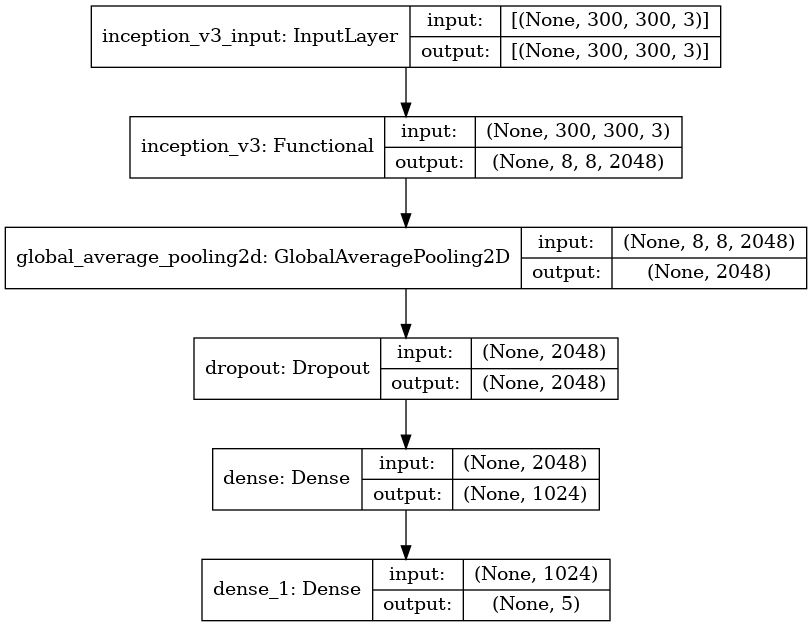

In [8]:
plot_model(model,
           show_shapes=True,
           show_layer_names=True)

In [9]:
batch_size = 32
epochs = 10

train_data_generator = img_data_generator["train_set"]
valid_data_generator = img_data_generator["valid_set"]

In [ ]:
steps_per_epoch = train_data_generator.n // batch_size
validation_steps = valid_data_generator.n // batch_size

In [11]:
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

In [12]:
checkpoint1 = ModelCheckpoint(filepath,
                              verbose=1,
                              mode='max',
                              monitor='val_accuracy',
                              save_best_only=True)
callbacks_list = [checkpoint1]

history = model.fit(train_data_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_data_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list)

model.save("plant_classification_inception.h5")

2022-09-09 22:36:46.091153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
108/108 [==============================] - 491s 4s/step - loss: 0.7708 - accuracy: 0.7331 - val_loss: 0.4245 - val_accuracy: 0.8341

Epoch 00001: val_accuracy improved from -inf to 0.83413, saving model to ./model_01-0.83.h5
Epoch 2/10
108/108 [==============================] - 467s 4s/step - loss: 0.5208 - accuracy: 0.8134 - val_loss: 0.4411 - val_accuracy: 0.8462

Epoch 00002: val_accuracy improved from 0.83413 to 0.84615, saving model to ./model_02-0.85.h5
Epoch 3/10
108/108 [==============================] - 461s 4s/step - loss: 0.4750 - accuracy: 0.8236 - val_loss: 0.4068 - val_accuracy: 0.8534

Epoch 00003: val_accuracy improved from 0.84615 to 0.85337, saving model to ./model_03-0.85.h5
Epoch 4/10
108/108 [==============================] - 479s 4s/step - loss: 0.4418 - accuracy: 0.8327 - val_loss: 0.3900 - val_accuracy: 0.8558

Epoch 00004: val_accuracy improved from 0.85337 to 0.85577, saving model to ./model_04-0.86.h5
Epoch 5/10
108/108 [===========================

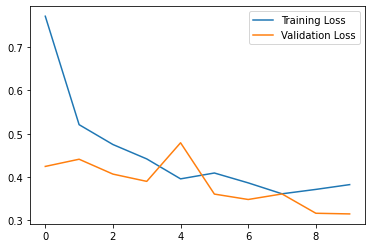

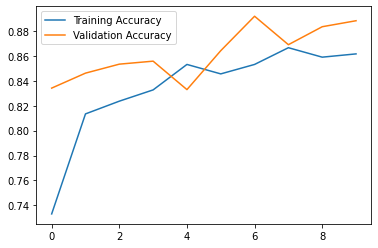

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()
plt.savefig("AccVal_acc")

In [56]:
best_model = keras.models.load_model("./model_07-0.89.h5")

def predict(img_rel_path):
    img = image.load_img(img_rel_path, target_size=(300, 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
    
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()
    
    pred = best_model.predict(img[np.newaxis, ...])
    
    labels = {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

    predicted_class = labels[np.argmax(pred[0], axis=-1)]
    print(predicted_class)
    print(np.max(pred[0], axis=-1))
    

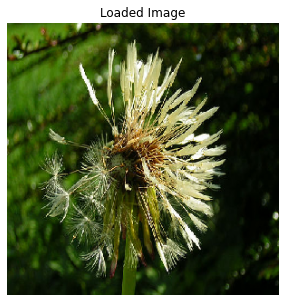

dandelion
0.99953246


In [61]:
predict("../input/flowers-recognition/flowers/dandelion/10683189_bd6e371b97.jpg")

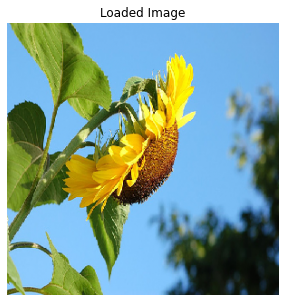

sunflower
0.9781763


In [62]:
predict("../input/flowers-recognition/flowers/sunflower/1240624822_4111dde542.jpg")

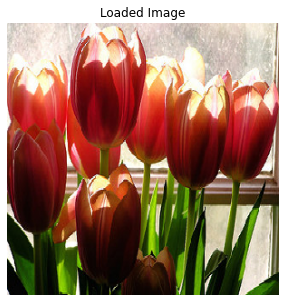

tulip
0.99156976


In [63]:
predict("../input/flowers-recognition/flowers/tulip/113291410_1bdc718ed8_n.jpg")